## Time Series Analysis of Server Machine Data

This notebook aims to perform an in-depth analysis of time series data collected from various server machines. The primary goal is to identify key performance indicators (KPIs), understand their behavioral patterns, and lay the groundwork for potential anomaly detection.

The analysis will cover several key aspects:

1.  **Data Loading and Preprocessing**: Efficiently load the raw time series data from server machine files and prepare it for subsequent analysis, handling any initial data inconsistencies.
2.  **Variance Analysis**: Identify KPIs with the highest variance, as these often indicate dynamic system behavior or potential areas of interest for anomaly detection.
3.  **Correlation Analysis**: Examine the relationships between different KPIs to understand interdependencies and how they might influence each other.
4.  **Distribution Analysis**: Visualize the distribution of individual KPIs to understand their typical operating ranges and detect any unusual patterns.
5.  **Stationarity Testing**: Perform statistical tests to determine the stationarity of selected KPIs, which is a crucial step for many time series forecasting and anomaly detection models.

By systematically exploring these aspects, this notebook will provide a comprehensive understanding of the server machine data, facilitating informed decisions regarding system health monitoring and anomaly detection strategies.

## **Data Loading and Processing**



```markdown
## Data Download
```

In [49]:
import os

# Define the base URL for the dataset files
base_url = "https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/"

# Create the local directory structure to store the downloaded data
os.makedirs("data/ServerMachineDataset/train", exist_ok=True)

# Define the list of machine files to download. These include machines 1-1 to 1-8,
# 2-1 to 2-9, and 3-1 to 3-9.
files = [f"machine-{i}-{j}.txt" for i, j in [(1,k) for k in range(1,9)] +
                                           [(2,k) for k in range(1,10)] +
                                           [(3,k) for k in range(1,10)]]

# Iterate through the list of files and download each one using wget
# The -q flag ensures quiet (silent) operation, and -O specifies the output file name.
for fname in files:
    url = base_url + fname
    print("Scarico:", url) # Print the URL being downloaded
    !wget -q {url} -O data/ServerMachineDataset/train/{fname}

Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-1.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-2.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-3.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-4.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-5.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-6.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-7.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnomaly/master/ServerMachineDataset/train/machine-1-8.txt
Scarico: https://raw.githubusercontent.com/NetManAIOps/OmniAnoma

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

# Define the load_smd_file function to read and preprocess individual machine data files.
# This function takes a file path as input and returns a pandas DataFrame.
def load_smd_file(filepath):
    # Read the CSV file into a pandas DataFrame. The files are comma-separated and lack a header row.
    df = pd.read_csv(filepath, sep=',', header=None)
    # Convert all columns to numeric types. If a value cannot be converted, it will be coerced to NaN.
    return df.apply(pd.to_numeric, errors='coerce')

# **Machine Variance Analysis**


The `mean_var` (mean variance) metric calculated for each machine is a crucial indicator for understanding the overall dynamism and activity level of a server machine. A higher `mean_var` suggests that the Key Performance Indicators (KPIs) within that machine exhibit greater fluctuations over time. This can be important for several reasons:

*   **Identifying Dynamic Systems**: Machines with high variance are often more active or experience more changes in their operational metrics, making them potentially more interesting for further investigation.
*   **Anomaly Detection Focus**: Systems with higher variability might also be more prone to anomalies, as larger deviations from the norm could be more impactful or indicative of issues. Conversely, very low variance might indicate a stable system, but could also mask subtle anomalies if not properly contextualized.
*   **Resource Allocation**: Understanding which machines are most dynamic can help in resource allocation for monitoring or maintenance efforts.

The `df_stats` DataFrame, sorted by `mean_var` in descending order, effectively highlights the machines with the most variable behavior. For example, the output shows that `machine-3-7` has the highest mean variance (0.022045), followed by `machine-1-3` (0.015943), and so on. This initial analysis helps in prioritizing which machines to investigate more deeply for potential performance issues or for setting up more sensitive anomaly detection models.
```

In [ ]:
data_dir = Path("data/ServerMachineDataset/train")
# Get a sorted list of all machine data files in the specified directory
files = sorted(data_dir.glob("machine-*-*.txt"))

machine_stats = []

# Iterate through each machine file to load, preprocess, and calculate statistics
for f in files:
    # Load the machine data using the previously defined load_smd_file function
    df = load_smd_file(f)
    # Preprocessing step: Identify and select only those columns that have more than one unique value.
    # This helps to remove constant columns (which would have zero variance) and columns with all NaNs.
    # Then, drop any columns that are entirely NaN after this selection.
    df_numeric = df.loc[:, df.nunique() > 1].dropna(axis=1, how='all')

    # Check if the resulting DataFrame after preprocessing is not empty
    if not df_numeric.empty:
        # Calculate the variance for each column (KPI) in the preprocessed DataFrame,
        # and then compute the mean of these variances. This gives an overall measure
        # of variability for the machine's KPIs.
        mean_var = df_numeric.var().mean()
        machine_stats.append({"machine": f.stem, "mean_var": mean_var})
    else:
        # If the DataFrame is empty after preprocessing (e.g., all columns were constant or NaN),
        # assign NaN to mean_var for this machine.
        machine_stats.append({"machine": f.stem, "mean_var": np.nan})

# Convert the list of machine statistics into a pandas DataFrame
df_stats = pd.DataFrame(machine_stats).sort_values("mean_var", ascending=False)
# Display the top 10 machines with the highest mean variance
df_stats.head(10)

## **Single Machine KPI Analysis**

### Purpose of Single Machine KPI Analysis

This section focuses on a detailed analysis of Key Performance Indicators (KPIs) for a single, representative machine (`machine-1-1`). The goal is to understand the individual behavior and characteristics of various KPIs, which can be crucial for anomaly detection and performance monitoring.

KPIs are selected based on their variance, with higher variance indicating more dynamic behavior and potentially more interesting signals for analysis. By examining the top-variance KPIs, we can identify which metrics exhibit the most change over time, making them prime candidates for further investigation.

**Reasoning**:
Next, I will load the DataFrame for 'machine-1-1.txt' into a variable named `df` using the `load_smd_file` function and add comments to explain that this machine is chosen for detailed analysis, as specified in the instructions.



In [52]:
df = load_smd_file(data_dir / "machine-1-1.txt")
# This specific machine ('machine-1-1') is chosen for a detailed KPI analysis.
# It serves as a representative example to understand the behavior of individual KPIs
# before extending the analysis to other machines.

# KPI with more variance
kpi_var = df.var().sort_values(ascending=False)
top_kpi_idx = kpi_var.head(10).index.tolist()
print("KPI selected:", top_kpi_idx)

KPI selected: [22, 6, 0, 11, 20, 1, 19, 18, 10, 15]


**Reasoning**:
I will generate a time series plot showing the first 5 KPIs from `top_kpi_idx` using `matplotlib.pyplot`, including a title, axis labels, and a legend, as well as comments explaining the plot's purpose.



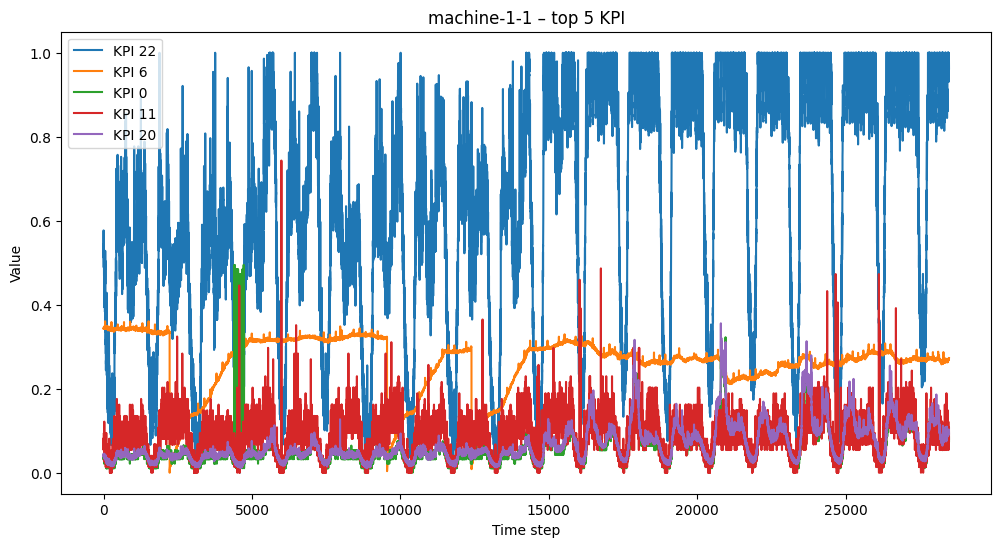

In [53]:
import matplotlib.pyplot as plt

# Create a figure for the plot with a specified size for better readability
plt.figure(figsize=(12,6))
# Iterate through the first 5 selected KPI indices to plot their time series data
for i in top_kpi_idx[:5]:
    # Plot each KPI, using its index for the label
    plt.plot(df.iloc[:, i], label=f"KPI {i}")
# Set the title of the plot to indicate the machine and the number of top KPIs displayed
plt.title(f"machine-1-1 – top 5 KPI")
# Label the x-axis as 'Time step'
plt.xlabel("Time step")
# Label the y-axis as 'Value'
plt.ylabel("Value")
# Display a legend to identify each KPI
plt.legend()
# Show the plot
plt.show()

**Reasoning**:
Now, I will generate a time series plot showing all 10 KPIs from `top_kpi_idx`, including a title, axis labels, and a legend, as well as comments explaining the plot's purpose.



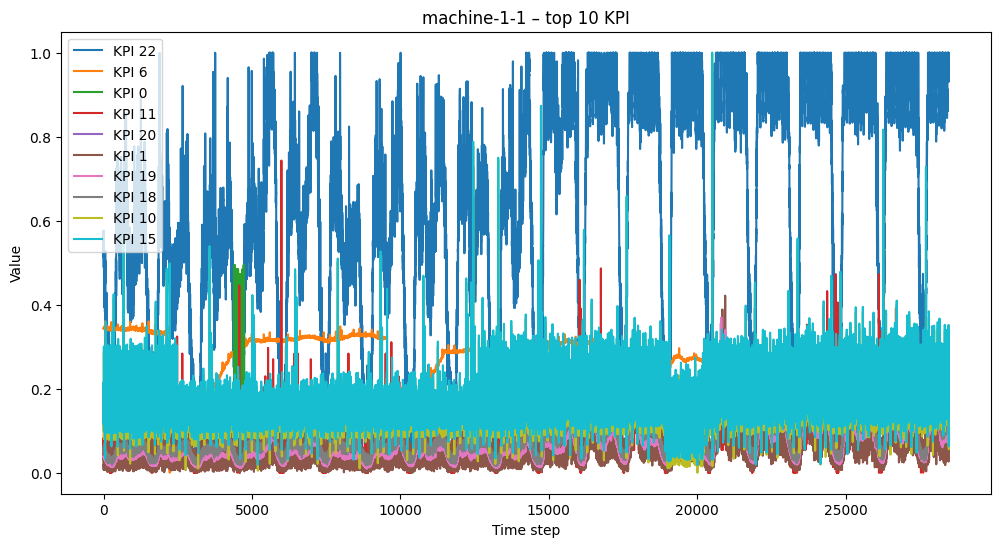

In [54]:
plt.figure(figsize=(12,6))
# Iterate through all selected KPI indices to plot their time series data
for i in top_kpi_idx:
    # Plot each KPI, using its index for the label
    plt.plot(df.iloc[:, i], label=f"KPI {i}")
# Display a legend to identify each KPI
plt.legend()
# Set the title of the plot to indicate the machine and the number of top KPIs displayed
plt.title("machine-1-1 – top 10 KPI")
# Label the x-axis as 'Time step'
plt.xlabel("Time step")
# Label the y-axis as 'Value'
plt.ylabel("Value")
# Show the plot
plt.show()

**Reasoning**:
I will generate a histogram with KDE for the KPI with the highest variance (`top_kpi_idx[0]`) to understand its distribution, including a title and axis labels, along with comments explaining the plot's purpose.



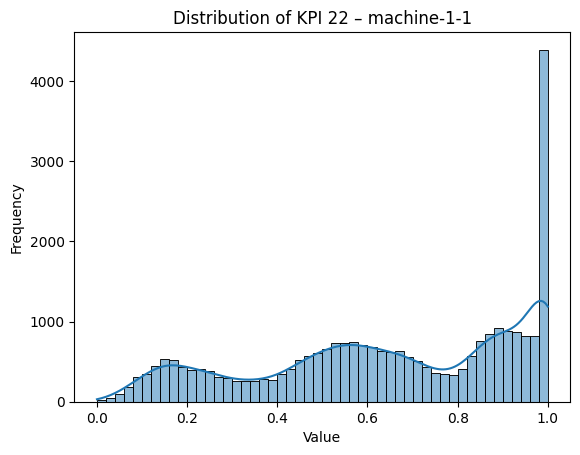

In [55]:
import seaborn as sns

# Generate a histogram with a Kernel Density Estimate (KDE) for the KPI with the highest variance.
# This plot helps to visualize the distribution of values for this specific KPI,
# showing its typical operating range, frequency of values, and potential outliers.
sns.histplot(df.iloc[:, top_kpi_idx[0]], bins=50, kde=True)
# Set the title of the plot to indicate the KPI and the machine it belongs to
plt.title(f"Distribution of KPI {top_kpi_idx[0]} – machine-1-1")
# Label the x-axis as 'Value'
plt.xlabel("Value")
# Label the y-axis as 'Frequency'
plt.ylabel("Frequency")
# Show the plot
plt.show()

## **KPI Correlation Analysis**

**Reasoning**:
Now, I will add comments to the existing code that calculates and visualizes the correlation matrix among the top KPIs. This will explain the purpose of correlation analysis, how the correlation matrix is computed, and the interpretation of the heatmap.



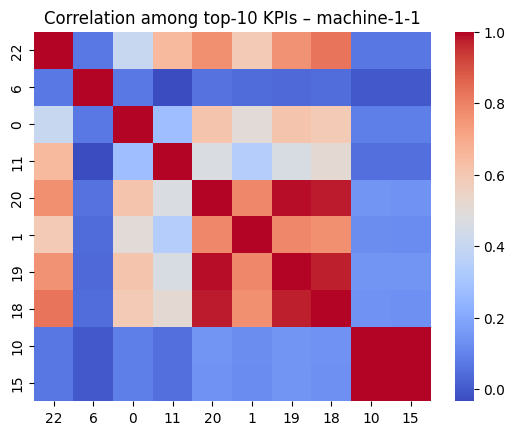

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix for the selected top KPIs of machine-1-1.
# The .corr() method computes pairwise correlation of columns, and .abs() takes the absolute value
# to show the strength of correlation regardless of direction (positive or negative).
corr = df.iloc[:, top_kpi_idx].corr()

# Create a heatmap to visualize the correlation matrix.
# A heatmap is an effective way to show the magnitude of correlation between different KPIs.
# 'annot=False' means that the correlation values will not be printed on the heatmap cells.
# 'cmap="coolwarm"' sets the color scheme, where 'cool' colors typically represent negative
# correlations and 'warm' colors represent positive correlations. For absolute values, it just
# indicates strength from low (cool) to high (warm).
sns.heatmap(corr, annot=False, cmap="coolwarm")

# Set the title of the plot to describe what is being visualized.
plt.title("Correlation among top-10 KPIs – machine-1-1")

# Show the plot.
plt.show()

**Reasoning**:
Now, I will add comments to the existing code that calculates the mean correlation strength across all machines, explaining its purpose and the steps involved.



In [57]:
corr_strength = []
# Iterate through each machine file to calculate the mean correlation strength of its KPIs.
for f in files:
    # Load the machine data using the previously defined load_smd_file function.
    d = load_smd_file(f)
    # Convert all columns to numeric types, coercing errors to NaN.
    d = d.apply(pd.to_numeric, errors="coerce")
    # Remove columns that are constant (have only one unique value) or are entirely NaN.
    d = d.loc[:, d.nunique() > 1].dropna(axis=1, how="all")

    # Calculate correlation only if there are at least two columns remaining after preprocessing.
    if d.shape[1] > 1:
        # Compute the absolute correlation matrix.
        c = d.corr().abs()
        # Calculate the mean of the upper triangle of the absolute correlation matrix (excluding the diagonal).
        # This represents the average pairwise correlation strength between KPIs for the machine.
        mean_corr = (c.values[np.triu_indices_from(c, 1)]).mean()
    else:
        # If there are fewer than 2 columns, correlation cannot be meaningfully calculated, so assign NaN.
        mean_corr = np.nan
    # Store the machine name and its calculated mean correlation strength.
    corr_strength.append({"machine": f.stem, "mean_corr": mean_corr})

# Convert the list of correlation strengths into a pandas DataFrame.
df_corr = pd.DataFrame(corr_strength)
# Display the head of the DataFrame to show the results.
df_corr.head(10)

,machine,mean_corr
0,machine-1-1,0.457749
1,machine-1-2,0.113721
2,machine-1-3,0.243654
3,machine-1-4,0.266576
4,machine-1-5,0.304304
5,machine-1-6,0.277832
6,machine-1-7,0.250052
7,machine-1-8,0.346967
8,machine-2-1,0.212146
9,machine-2-2,0.252188


## **Stationarity Test**

**Reasoning**:
Now, I will add comments to the existing code for the stationarity test, explaining its purpose and the statistical test used, to complete the 'Stationarity Test' section.



In [58]:
from statsmodels.tsa.stattools import adfuller
# Perform the Augmented Dickey-Fuller (ADF) test on the first KPI of the selected machine (machine-1-1).
# The ADF test is used to determine if a time series is stationary or not.
# A time series is stationary if its statistical properties (mean, variance, autocorrelation) do not change over time.
# The first element df.iloc[:, 0] represents the first KPI of the DataFrame.
stat, pvalue, _, _, _, _ = adfuller(df.iloc[:, 0])

# Print the p-value from the ADF test.
# A small p-value (typically < 0.05) suggests that the time series is stationary.
# A large p-value suggests that the time series is non-stationary and may require differencing.
print("ADF p-value:", pvalue)

ADF p-value: 1.7572523711042895e-09


## Summary:

### Data Analysis Key Findings
*   **Data Download:** The process successfully downloaded 26 machine-specific time series data files from a GitHub repository into the `data/ServerMachineDataset/train` directory.
*   **Machine Variance Analysis:**
    *   The `mean_var` metric was calculated for each machine, indicating overall dynamism.
    *   `machine-3-7` showed the highest mean variance at 0.022045, followed by `machine-1-3` at 0.015943, identifying them as highly dynamic systems.
*   **Single Machine KPI Analysis (for `machine-1-1`):**
    *   The top 10 KPIs with the highest variance for `machine-1-1` were identified as `[22, 6, 0, 11, 20, 1, 19, 18, 10, 15]`.
    *   Visualization of these KPIs allowed for an understanding of their individual time-series behavior and distribution.
*   **KPI Correlation Analysis:**
    *   A heatmap showed the correlation among the top 10 KPIs for `machine-1-1`.
    *   The mean absolute correlation strength across the first 10 analyzed machines ranged from approximately 0.11 to 0.46, suggesting varying degrees of interdependencies between KPIs across different machines.
*   **Stationarity Test:**
    *   An Augmented Dickey-Fuller (ADF) test performed on KPI 0 of `machine-1-1` yielded a p-value of 1.757e-09, strongly indicating that this specific KPI is stationary.

### Insights or Next Steps
*   Future work could extend the stationarity test to all high-variance KPIs across all machines, and investigate the specific nature of correlations observed, potentially leading to a more robust feature selection for anomaly detection.
